In [1]:
import os
import json
import ast
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from openai import OpenAI

# Update with your file
CSV_PATH = "chunks_with_hdbscan_clusters_and_labels_from_weaviate_HDBSCAN.csv"

df = pd.read_csv(CSV_PATH)

print("Loaded", len(df), "rows")
df.head()

Loaded 5000 rows


,_id,embedding,chunk_id,doc_id,text,umap_0,umap_1,umap_2,umap_3,umap_4,cluster_id,cluster_name,cluster_summary,num_examples
0,000203a2-f584-43f1-8527-e167b0bf8c6e,"[-0.006832002, 0.058254257, 0.033376772, 0.006...",016697_c937,16697,0024-001 3181903 0 3181903 RES N 50-43-43-10-1...,7.195254,1.112832,3.265973,1.244541,-1.418556,2,Residential Property Identifiers and Details,This cluster contains a series of residential ...,25
1,00046a59-5d95-4bdd-9bef-2acc2feead61,"[-0.0023835688, 0.040449306, 0.038565286, 0.02...",023731_c153,23731,"scholars. But, in a way, he was very wrong. Y...",10.077652,-0.304295,-1.325785,2.636469,9.584307,11,Culinary Disasters and Life Lessons,This cluster explores the intersection of cook...,25
2,0008b585-596a-42b9-8d0a-9be00a32b994,"[-0.028839508, -0.014247406, -0.013418496, 0.0...",027333_c015,27333,5 Is Read: Yes Is Invitation: No GUID: 734F669...,7.174623,-1.099862,0.594156,-4.138259,5.630887,3,Political Discussions and Economic Views,The messages focus on discussions surrounding ...,25
3,00091260-d45d-4f44-bb4e-8100c280de0e,"[0.042262483, 0.022982152, 0.054571044, 0.0609...",025231_c005,25231,-mail message is subject to the Dubai World Gr...,10.190465,-1.439499,-1.401053,-1.711499,4.959008,22,Legal Communication and Oversight,This cluster focuses on legal communications r...,25
4,00099043-8c80-4015-8d4c-6912225c5d60,"[0.015008055, -0.00056260754, -0.024414347, 0....",017088_c153,17088,for a return of McCarthyism or for military h...,11.088724,0.396161,-2.188416,-1.018357,8.639958,23,Freedom of Speech and Privacy Rights,This cluster discusses the complexities of fre...,25


In [2]:
def parse_embedding(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return json.loads(x)
        except json.JSONDecodeError:
            return ast.literal_eval(x)
    raise ValueError("Unsupported embedding format")

emb_list = df["embedding"].apply(parse_embedding).tolist()
X = np.array(emb_list, dtype=np.float32)

print("Embedding matrix shape:", X.shape)

X_norm = normalize(X, norm="l2", axis=1)
print("Done normalization.")

labels = df["cluster_id"].values
sil_score = silhouette_score(X_norm, labels)

print("Silhouette Score =", round(sil_score, 4))

Embedding matrix shape: (5000, 1536)
Done normalization.
Silhouette Score = 0.0607


Smallest cluster: 52
Largest cluster: 752
Median cluster size: 107.0


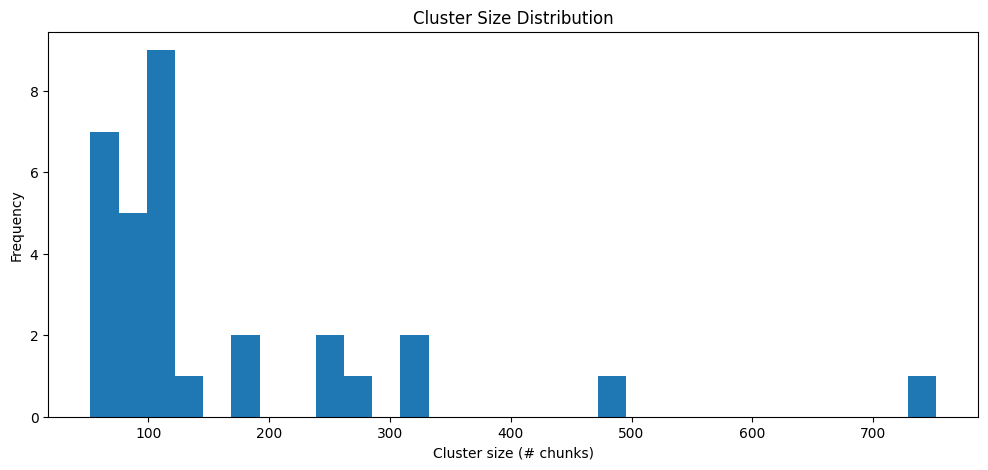

In [3]:
size_series = df["cluster_id"].value_counts().sort_index()
size_series

print("Smallest cluster:", size_series.min())
print("Largest cluster:", size_series.max())
print("Median cluster size:", size_series.median())

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.hist(size_series, bins=30)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster size (# chunks)")
plt.ylabel("Frequency")
plt.show()

In [4]:
n_clusters = df["cluster_id"].nunique()

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10
).fit(X_norm)

df["cluster_id_recomputed"] = kmeans.labels_

def get_representatives(cluster_id, top_k=15):
    idx = np.where(df["cluster_id_recomputed"].values == cluster_id)[0]
    cluster_vectors = X_norm[idx]
    centroid = kmeans.cluster_centers_[cluster_id]

    scores = cluster_vectors @ centroid
    order = np.argsort(-scores)

    reps = df.iloc[idx[order[:top_k]]]
    return reps[["chunk_id", "text"]]

cluster_to_inspect = 0   # change this number 0..(k-1)

reps = get_representatives(cluster_to_inspect)
for cid, txt in zip(reps["chunk_id"], reps["text"]):
    print("\n---", cid, "---\n")
    print(txt[:500], "...\n")   # print first 500 chars


--- 027307_c016 ---

E0 Message: K Sender: e:jeeitunes gmail.com Time: 07/05/18 07:20:18 AM (552493218) Flags: 1150981 Is Read: No Is Invitation: No GUID: CC908826-29FE-4518-99CB-668C3E471124 Message: Chat later today? HOUSE OVERSIGHT 027316 Sender: Time: 07/05/18 07:44:21 AM (552494661) Flags: 1060865 Is Read: Yes Is Invitation: No GUID: E6E1812C-B22F-4C08-A31D-63EFC573B6EC Message: Yes Sender: e:jeeitunes gmail.com Time: 07/05/18 02:54:58 PM (552520498) Flags: 1085445 Is Read: No Is Invitation: No GUID: 3A07888D-2 ...


--- 027764_c009 ---

:35:01 PM (582154501) Flags: 1085445 Is Read: No Is Invitation: No GUID: 05966503-5D13-4B16-846D-DEB6AB1A3OBC Message: He wanted to be careful as he doesn't want your contact known Sender: e:jeeitunes gmail.com Time: 06/13/19 02:35:15 PM (582154515) Flags: 1085445 Is Read: No Is Invitation: No GUID: 6BD87B81-1138-4AD7-B642-B107FB065C54 Message: I'll figure it out Sender: Time: 06/13/19 02:35:17 PM (582154517) Flags: 1060865 Is Read: Yes Is Invita

In [ ]:
client = OpenAI(api_key="KEY_HERE")
MODEL = "gpt-4o-mini-2024-07-18"

def llm_validate_cluster(cluster_id, top_k=10):
    reps = get_representatives(cluster_id, top_k=top_k)
    combined = "\n\n".join(reps["text"].tolist())
    combined = combined[:8000]

    system_msg = (
        "You are an analyst validating document clusters. "
        "Given several paragraphs that allegedly belong to the same cluster, "
        "determine if they form a coherent topic. "
        "Return JSON with: {coherent: true/false, explanation: 'text'}."
    )

    resp = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_msg},
            {"role": "user", "content": combined},
        ],
        response_format={"type": "json_object"},
    )

    return json.loads(resp.choices[0].message.content)

In [6]:
# Validate all clusters with LLM coherence test

all_results = []

total_clusters = df["cluster_id"].nunique()
print("Total clusters:", total_clusters)

for cid in range(total_clusters):
    try:
        print(f"\n=== Checking cluster {cid} ===")
        result = llm_validate_cluster(cid, top_k=10)  # or top_k=15 if chunks are short

        all_results.append({
            "cluster_id": cid,
            "coherent": result.get("coherent"),
            "explanation": result.get("explanation", ""),
        })

        print(f"Cluster {cid} coherent? {result.get('coherent')}")
    except Exception as e:
        print(f"Error on cluster {cid}:", e)
        all_results.append({
            "cluster_id": cid,
            "coherent": None,
            "explanation": f"ERROR: {e}"
        })

print("\nCompleted LLM validation on all clusters.")

Total clusters: 31

=== Checking cluster 0 ===
Cluster 0 coherent? False

=== Checking cluster 1 ===
Cluster 1 coherent? False

=== Checking cluster 2 ===
Cluster 2 coherent? False

=== Checking cluster 3 ===
Cluster 3 coherent? False

=== Checking cluster 4 ===
Cluster 4 coherent? True

=== Checking cluster 5 ===
Cluster 5 coherent? True

=== Checking cluster 6 ===
Cluster 6 coherent? False

=== Checking cluster 7 ===
Cluster 7 coherent? False

=== Checking cluster 8 ===
Cluster 8 coherent? False

=== Checking cluster 9 ===
Cluster 9 coherent? True

=== Checking cluster 10 ===
Cluster 10 coherent? True

=== Checking cluster 11 ===
Cluster 11 coherent? False

=== Checking cluster 12 ===
Cluster 12 coherent? False

=== Checking cluster 13 ===
Cluster 13 coherent? False

=== Checking cluster 14 ===
Cluster 14 coherent? False

=== Checking cluster 15 ===
Cluster 15 coherent? True

=== Checking cluster 16 ===
Cluster 16 coherent? True

=== Checking cluster 17 ===
Cluster 17 coherent? False

In [7]:
coh_df = pd.DataFrame(all_results)
coh_df.to_csv("cluster_coherence_results.csv", index=False)
coh_df

print("\n=== Cluster Coherence Summary ===")

good = coh_df[coh_df["coherent"] == True]
bad  = coh_df[coh_df["coherent"] == False]
unknown = coh_df[coh_df["coherent"].isna()]

print("Coherent clusters:", len(good))
print("Incoherent clusters:", len(bad))
print("Errors / unknown:", len(unknown))

print("\nIncoherent cluster IDs:")
print(bad["cluster_id"].tolist())



=== Cluster Coherence Summary ===
Coherent clusters: 11
Incoherent clusters: 20
Errors / unknown: 0

Incoherent cluster IDs:
[0, 1, 2, 3, 6, 7, 8, 11, 12, 13, 14, 17, 20, 23, 24, 25, 26, 27, 28, 30]


In [8]:
k = df["cluster_id"].nunique()

labels1 = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_norm)
labels2 = KMeans(n_clusters=k, random_state=123, n_init=10).fit_predict(X_norm)

ari = adjusted_rand_score(labels1, labels2)
print("Adjusted Rand Index:", round(ari, 4))

Adjusted Rand Index: 0.7266
